# <center>Lanczos Algorithm</center>

Lanczos algorithm is a numerical method used to find the eigenvalues and eigenvectors of large matrices. It is particularly useful in quantum mechanics, where for many-body systems dimension of the <i>Hilbert space</i> grows exponentially with system size. It allows to find ground states of sparse hamiltonians very efficiently by employing <i>Krylov subspace</i> iteration methods. A brief description of the algorithm is presented below.

First we create a random vector inside system's <i>Hilbert space</i>:

### $$|\psi_0\rangle = \sum_b\alpha_b|b\rangle$$

Where $|b\rangle$ is a set of all $2^L$ vectors from Hilbert space of size $L$, $\alpha_b \in (-\frac{1}{2}, \frac{1}{2})$ is a random number. Then we apply the hamiltonian to it and we get:

### $$\hat{H}|\psi_o\rangle = a_0|\psi_o\rangle + b_1|\psi_1\rangle$$

And the goal is to find $b_1$ and $|\psi_1\rangle$. So applied hamiltonian we mark as:

### $$\hat{H}|\psi_0\rangle = |\phi_1\rangle$$

$|\phi_1\rangle$ is a temporary vector to allow further calculations:

### $$|\phi_2\rangle = |\phi_1\rangle - a_0|\psi_0\rangle = b_1|\psi_1\rangle$$

And we get:

### $$\langle \phi_2|\phi_2\rangle = |b_1|^2\langle \psi_1|\psi_1\rangle = |b_1|^2 \Rightarrow$$

### $$b_1 = \sqrt{\langle \phi_2|\phi_2\rangle} \Rightarrow |\psi_1\rangle = \frac{|\phi_2\rangle}{b_1}$$

Now we repeat the whole process, but one additional step is needed - we add third term to hamiltonian multiplication:

### $$\hat{H}|\psi_1\rangle = b_1|\psi_0\rangle + a_1|\psi_1\rangle + b_2|\psi_2\rangle$$

And we calculate new coefficients exactly the same way:

### $$|\phi_2\rangle = \hat{H}|\psi_1\rangle - a_1|\psi_1\rangle - b_1|\psi_0\rangle$$

We calculate $b_2$ and $|\psi_2\rangle$:

### $$b_2 = \sqrt{\langle |\psi_2|\phi_2\rangle} \Rightarrow |\psi_2\rangle = \frac{|\phi_2\rangle}{b_2}$$

We see that there is a pattern - we can write everything in a more general form:

### $$\hat{H}|\psi_i\rangle = b_i|\psi_{i-1}\rangle + a_i|\psi_i\rangle + b_{i+1}|\psi_{i+1}\rangle$$

### $$a_i = \langle \psi_i|\hat{H}|\psi_i\rangle \Rightarrow b_i = \langle \psi_{i-1}$$

### $$b_{i+1} = \sqrt{\langle \phi_2|\phi_2\rangle} \Rightarrow |\phi_2\rangle = \hat{H}|\psi_i\rangle - a_i|\psi_i\rangle - b_i|\phi_{i-1}\rangle$$

Each Lanczos step changes matrix size and calculates new coefficients diagonally:

### $$\tilde{H} = \begin{bmatrix}a_0\end{bmatrix} \Rightarrow \begin{bmatrix}a_0 & b_1 \\ b_1 & a_1\end{bmatrix} \Rightarrow \begin{bmatrix} a_0 & b_1 &  \\ b_1 & a_1 & b_2 \\  & b_2 & a_2\end{bmatrix} \Rightarrow \cdots \Rightarrow \begin{bmatrix}a_0 & b_1 \\ b_1 & a_1 & b_2 \\ & b_2 & \ddots & \ddots \\ & & \ddots & \ddots & b_{n-2} \\ & & & b_{n-2} & a_{n-2} & b_{n-1} \\ & & & & b_{n-1} & a_{n-1}\end{bmatrix}$$

After $n$ Lanczos steps we have $n \times n$ matrix. After enough steps extreme eigenvalues converge quickly to real ones and we got the results much more efficiently. Let's implement it in a code.

In [1]:
import sys
sys.path.append('..')

In [2]:
from HamiltonianClass import QuantumState
import numpy as np
import ipywidgets
from matplotlib import pyplot as plt

# variables used to improve notation
rangle = r'\rangle'
til_H = r'\tilde{H}'

In [3]:
L, J, delta = 6, 1, 1
quantum_state = QuantumState(L, J, delta, is_reduced=True, is_pbc=False)

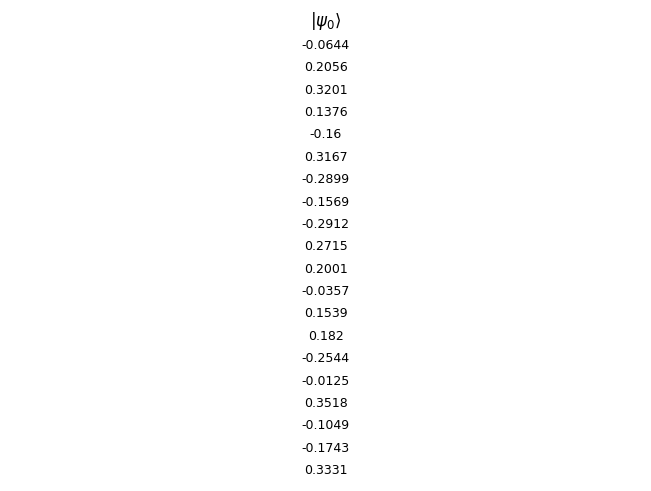

In [4]:
random_vector = quantum_state.set_random_state_vector(assign=False)

fig1, ax1 = plt.subplots(1, 1, layout='constrained')
ax1.set_title(r'$|\psi_0\rangle$')
quantum_state.plot_data(matrix=random_vector, axes=ax1)
plt.show()

Whole Lanczos step presented in theoretical introduction is executed by function <i>Lanczos_step</i> built into <i>QuantumState</i> object. Let's execute it a couple of times and see how vector changes.

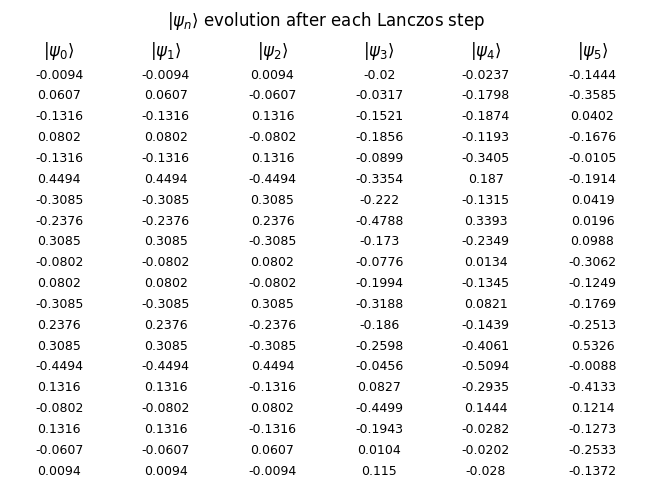

In [5]:
steps = 5
fig2, ax2 = plt.subplots(1, steps + 1, layout='constrained')
fig2.suptitle(f'$|\psi_n{rangle}$ evolution after each Lanczos step')
ax2[0].set_title(r'$|\psi_0\rangle$')
quantum_state.plot_data(matrix=quantum_state.get_state_vector(), axes=ax2[0])
for i in range(1, steps + 1):
    quantum_state.lanczos_step()
    quantum_state.plot_data(matrix=quantum_state.get_lanczos_vector(), axes=ax2[i])
    ax2[i].set_title(f'$|\psi_{i}{rangle}$')
plt.show()

To reset all Lanczos calculations:

In [6]:
quantum_state.lanczos_reset()
quantum_state.set_random_state_vector()

Now let's see how Lanczos matrix changes after each step:

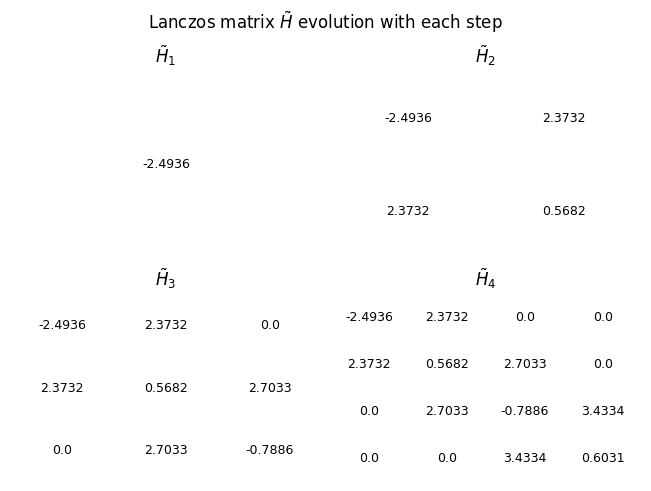

In [7]:
rows, cols = 2, 2
fig3, ax3 = plt.subplots(rows, cols, layout='constrained')
fig3.suptitle(r'Lanczos matrix $\tilde{H}$ evolution with each step')
for row in range(rows):
    for col in range(cols):
        quantum_state.lanczos_step()
        quantum_state.plot_data(matrix=quantum_state.get_lanczos_matrix(), axes=ax3[row][col])
        ax3[row][col].set_title(f'${til_H}_{quantum_state.lanczos_steps}$')
quantum_state.lanczos_reset()      

For more steps let's implement interactive plot:

In [8]:
def plot_lanczos_matrix(L, initial_vector, lanczos_steps=1):
    state = QuantumState(L, 1, 1, is_reduced=True, is_pbc=False)
    state.set_state_vector(initial_vector)
    state.do_n_lanczos_steps(lanczos_steps)

    figure, axes = plt.subplots(1, 1, layout='constrained')
    state.plot_data(matrix=state.get_lanczos_matrix(), axes=axes)
    axes.set_title(f'${til_H}_' + r'{' + f'{lanczos_steps}' + r'}$')

In [9]:
ipywidgets.interact(plot_lanczos_matrix,
                    L=ipywidgets.fixed(L),
                    initial_vector=ipywidgets.fixed(random_vector),
                    lanczos_steps=(1, 12, 1))

interactive(children=(IntSlider(value=1, description='lanczos_steps', max=12, min=1), Output()), _dom_classes=…

<function __main__.plot_lanczos_matrix(L, initial_vector, lanczos_steps=1)>

Now let's see how eigenvalues of Lanczos matrix change with each iteration. To do this we use <i>LanczosStep</i> object.

In [10]:
from LanczosStep import LanczosStep
from matplotlib.ticker import MaxNLocator

In [11]:
def plot_lanczos_eigenvalues(L=6, lanczos_steps=20):
    lanczos_step = LanczosStep(J=1, L=L, delta=1,
                              is_pbc=False,
                              hamiltonian_reduced=True,
                              lanczos_steps=lanczos_steps)
    lanczos_step.simulate_lanczos_step(disable_print=True)
    
    figure, axes = plt.subplots(1, 1, layout='constrained')
    axes.scatter(lanczos_step.x_index, lanczos_step.y_energies,
                 marker='+', color='black', label='Lanczos eigenvalues')
    real_eigenvalues_index = np.full(len(lanczos_step.real_eigenvalues), lanczos_step.lanczos_steps + 1)
    axes.scatter(real_eigenvalues_index, lanczos_step.real_eigenvalues,
                 marker='x', color='blue', label='real eigenvalues')
    axes.set(xlabel='Lanczos step', ylabel='energies')
    axes.grid()
    axes.legend(loc='upper left')
    axes.set_title('Lanczos matrix eigenvalues')
    axes.xaxis.set_major_locator(MaxNLocator(integer=True))

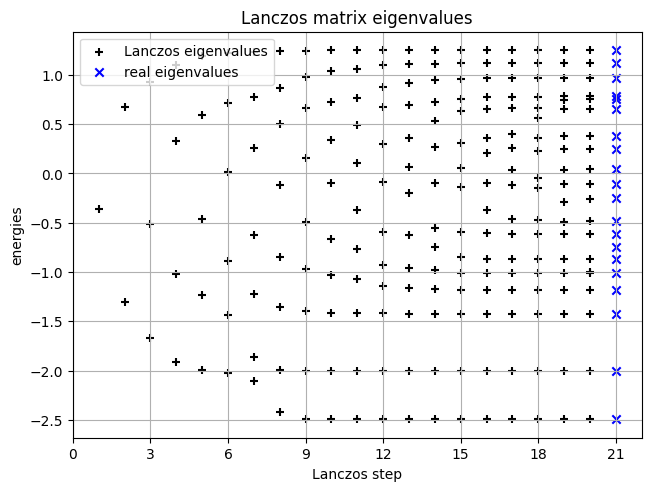

In [12]:
plot_lanczos_eigenvalues(6)

And last but not least let's tweak with lanczos steps in interactive plot:

In [13]:
ipywidgets.interact(plot_lanczos_eigenvalues,
                    L=[4, 6, 8, 10],
                    lanczos_steps=(1, 100, 1))

interactive(children=(Dropdown(description='L', index=1, options=(4, 6, 8, 10), value=6), IntSlider(value=20, …

<function __main__.plot_lanczos_eigenvalues(L=6, lanczos_steps=20)>